In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('/content/matches.csv')

In [16]:
df.drop(columns=["Unnamed: 0", "comp", "round", "attendance", "match report", "notes"], inplace=True)
df["date"] = pd.to_datetime(df["date"])
df['venue'] = df['venue'].astype('category')
df['opponent'] = df['opponent'].astype('category')
df['team'] = df['team'].astype('category')
df['result'] = df['result'].astype('category')
df['day'] = df['date'].dt.day_name()

df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df["day_code"] = df["date"].dt.dayofweek

In [17]:
df.duplicated().sum()

0

In [18]:
df.formation.value_counts()

,count
formation,
4-2-3-1,1382
4-3-3,1025
4-4-2,583
3-4-3,548
3-5-2,266
4-1-4-1,258
4-4-1-1,141
3-4-1-2,113
5-3-2,107


In [19]:
df.formation = df.formation.str.replace("◆", "")
df.formation = df.formation.str.replace("-0", "")

value_counts = df.formation.value_counts()
to_replace = value_counts[value_counts < 107].index
df['formation'] = df['formation'].replace(to_replace, 'Altro')

In [20]:
df['season'].value_counts()

,count
season,
2024,1520
2023,988
2022,760
2021,760
2020,760


In [21]:
df_cols = df.columns
df_cols = df_cols.drop('season')

In [22]:
df.duplicated(subset=df_cols).sum()

988

In [23]:
df.drop_duplicates(subset=df_cols, inplace=True)
df.duplicated(subset=df_cols).sum()

0

In [24]:
def get_correct_season(date):
    if isinstance(date, str):
        date = pd.to_datetime(date)
    if date.month >= 8:
        return date.year + 1
    else:
        return date.year

In [25]:
df['season'] = df['date'].apply(get_correct_season)
df['season'].value_counts().sort_index()

,count
season,
2020,760
2021,760
2022,760
2023,760
2024,760


In [27]:
df['points'] = df['result'].apply(lambda x: 3 if x == 'W' else 1 if x == 'D' else 0)
df['points'] = df['points'].astype('int')
winners = df.groupby(['season', 'team'], observed=False)['points'].sum().reset_index() \
  .sort_values(['season', 'points'], ascending=[True, False]) \
  .groupby('season', observed=False).first()

df['season_winner'] = df['season'].map(winners['team'])

In [29]:
def captains_func(data):
    if data['count'] == 0:
        data['count'] = np.nan
    return data

In [30]:
group = df.groupby('team', observed=False)['captain'].value_counts().reset_index(name='count')
group = group.apply(captains_func, axis=1)
group.dropna(inplace=True)
group = group.drop(columns='count')

group['team'].value_counts()
group[group['team'] == 'Liverpool']
df.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team,hour,day_code,points,season_winner
0,2020-09-21,20:15 (21:15),Monday,Away,W,3,1,Wolves,1.9,0.6,65,Fernandinho,4-2-3-1,Andre Marriner,13,8,21.1,2,1,1,2021,Manchester City,20,0,3,Manchester City
1,2020-09-27,16:30 (17:30),Sunday,Home,L,2,5,Leicester City,0.9,2.9,72,Fernandinho,4-2-3-1,Michael Oliver,16,5,19.8,1,0,0,2021,Manchester City,16,6,0,Manchester City
2,2020-10-03,17:30 (18:30),Saturday,Away,D,1,1,Leeds United,1.2,2.4,49,Kevin De Bruyne,4-3-3,Mike Dean,23,1,18.2,1,0,0,2021,Manchester City,17,5,1,Manchester City
3,2020-10-17,17:30 (18:30),Saturday,Home,W,1,0,Arsenal,1.3,0.9,58,Raheem Sterling,Altro,Chris Kavanagh,13,5,17.7,0,0,0,2021,Manchester City,17,5,3,Manchester City
4,2020-10-24,12:30 (13:30),Saturday,Away,D,1,1,West Ham,1.0,0.3,69,Raheem Sterling,4-3-3,Anthony Taylor,14,7,20.9,1,0,0,2021,Manchester City,12,5,1,Manchester City


In [31]:
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values(['team', 'date'])
df_sorted = df_sorted.reset_index(drop=True)

In [32]:
def verify_sorting(data):
    # Check if dates are in ascending order for each team
    is_sorted = data.groupby('team', observed=False)['date'].is_monotonic_increasing.all()

    if is_sorted:
        print("Data is correctly sorted by date for each team.")
    else:
        print("WARNING: Data is not correctly sorted. Please check for inconsistencies.")

In [33]:
verify_sorting(df_sorted)

Data is correctly sorted by date for each team.


In [34]:
num_cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'xga', 'xg', 'gf', 'ga']
for col in num_cols:
    df_sorted[col] = pd.to_numeric(df_sorted[col])

In [35]:
def calculate_fk_pk_ratios(data):
    data['fk_ratio'] = data['fk'] / data['sh']

    data['pk_conversion_rate'] = data['pk'] / data['pkatt']

    data['pk_per_shot'] = data['pkatt'] / data['sh']

    data['fk_ratio'] = data['fk_ratio'].replace([np.inf, -np.inf], np.nan)
    data['pk_conversion_rate'] = data['pk_conversion_rate'].replace([np.inf, -np.inf], np.nan)
    data['pk_per_shot'] = data['pk_per_shot'].replace([np.inf, -np.inf], np.nan)

    data['fk_percentage'] = data['fk_ratio'] * 100
    data['pk_conversion_percentage'] = data['pk_conversion_rate'] * 100
    data['pk_per_shot_percentage'] = data['pk_per_shot'] * 100

    return data

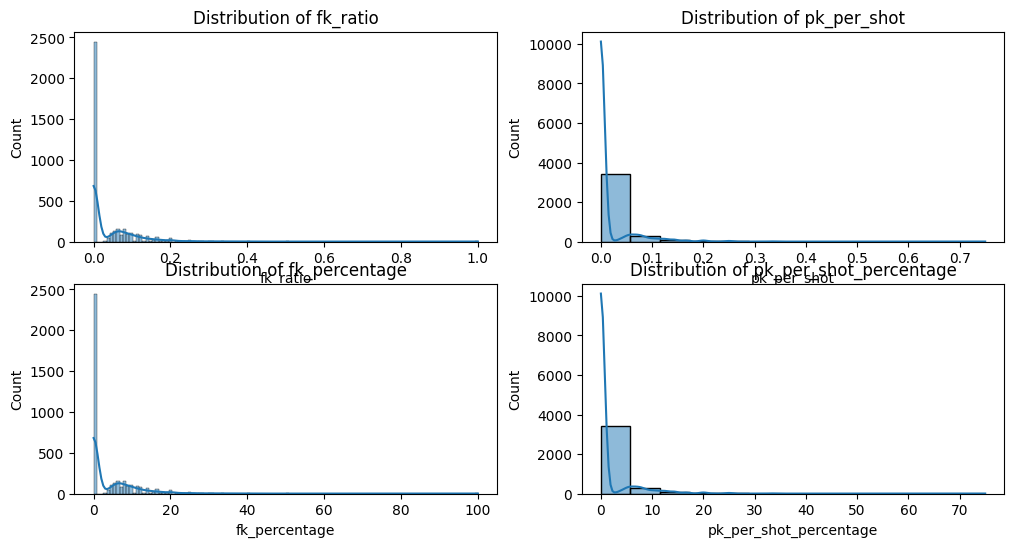

In [39]:
df_sorted = calculate_fk_pk_ratios(df_sorted)
df_sorted.drop(['pk_conversion_rate', 'pk_conversion_percentage'], axis=1, inplace=True)
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
i = 0
for col in ['fk_ratio', 'pk_per_shot', 'fk_percentage', 'pk_per_shot_percentage']:
    sns.histplot(df_sorted[col], kde=True, ax=axs.flatten()[i])
    axs.flatten()[i].set_title('Distribution of ' + col)
    i += 1

,fk_ratio,pk_per_shot,fk_percentage,pk_per_shot_percentage
mean,0.036645,0.012528,3.664499,1.25284
min,0.000000,0.000000,0.000000,0.00000
max,1.000000,0.750000,100.000000,75.00000


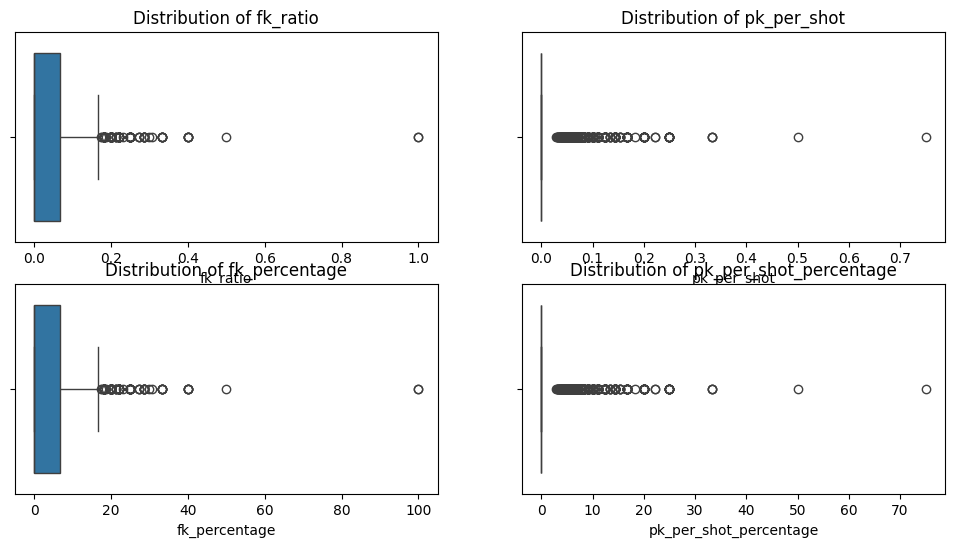

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
i = 0
for col in ['fk_ratio', 'pk_per_shot', 'fk_percentage', 'pk_per_shot_percentage']:
    sns.boxplot(x=df_sorted[col], ax=axs.flatten()[i])  # Changed to boxplot
    axs.flatten()[i].set_title('Distribution of ' + col)
    i += 1
df_sorted[['fk_ratio', 'pk_per_shot', 'fk_percentage', 'pk_per_shot_percentage']].agg(['mean', 'min', 'max'])

In [41]:
def calculate_rolling_average(data, column, window=5):
    """
    Calculate the rolling average of a column for each team.

    Parameters:
    data (DataFrame): The input DataFrame
    column (str): The column to calculate the rolling average for
    window (int): The number of games to include in the rolling average

    Returns:
    Series: The rolling average
    """
    return data.groupby('team', observed=False)[column].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

In [42]:
df_sorted['rolling_xg'] = calculate_rolling_average(df_sorted, 'xg')
df_sorted['rolling_xga'] = calculate_rolling_average(df_sorted, 'xga')
df_sorted['rolling_poss'] = calculate_rolling_average(df_sorted, 'poss')
df_sorted['rolling_sh'] = calculate_rolling_average(df_sorted, 'sh')
df_sorted['rolling_sot'] = calculate_rolling_average(df_sorted, 'sot')
df_sorted['rolling_dist'] = calculate_rolling_average(df_sorted, 'dist')

In [43]:
df_sorted['result_encoded'] = pd.to_numeric(df_sorted['result'].map({'W': 1, 'D': 0, 'L': -1}))
df_sorted['form'] = calculate_rolling_average(df_sorted, 'result_encoded')

In [44]:
df_sorted['goal_diff'] = df_sorted['gf'] - df_sorted['ga']
df_sorted['rolling_goal_diff'] = calculate_rolling_average(df_sorted, 'goal_diff')

In [45]:
def get_head_to_head(data):
    """
    Calculate the head-to-head record against each opponent.

    Returns:
    DataFrame: The original dataframe with an additional column for head-to-head record
    """
    # Calculate the mean result for each team-opponent pair
    h2h = data.groupby(['team', 'opponent'], observed=False)['result_encoded'].mean().reset_index()

    # Rename the mean column
    h2h = h2h.rename(columns={'result_encoded': 'h2h_record'})

    # Merge the h2h data back to the original dataframe
    result = pd.merge(data, h2h, on=['team', 'opponent'], how='left')

    return result

In [47]:
df_sorted = get_head_to_head(df_sorted)
df_sorted['day_of_week'] = pd.to_datetime(df_sorted['date']).dt.dayofweek

In [48]:
def categorize_time(time):
    hour = pd.to_datetime(time).hour
    if hour < 12:
        return 'early'
    elif hour < 17:
        return 'afternoon'
    else:
        return 'evening'

In [49]:
df_sorted['time'] = df_sorted['time'].apply(lambda x: x.split(' ')[0])
df_sorted['time_condition'] = df_sorted['time'].apply(categorize_time)

df_sorted['time_condition'].value_counts()

,count
time_condition,
afternoon,2338
evening,1462


In [50]:
df_sorted.groupby('team', observed=False)['date'].count().sort_values(ascending=False)
df_sorted['days_since_last_match'] = df_sorted.groupby('team', observed=False)['date'].diff().dt.days
df_sorted['days_since_last_match'] = df_sorted['days_since_last_match'].fillna(0)

In [51]:
df_sorted.to_csv('matches_final.csv', index=False)

In [52]:
columns_to_drop = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot',
                   'goal_diff', 'day', 'pk', 'pkatt', 'fk',
                   'referee', 'dist','points', 'season_winner', 'hour', 'result_encoded', 'day_code']
df_sorted = df_sorted.drop(columns=columns_to_drop)
num_cols = df_sorted.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['season'])
num_cols = num_cols.tolist()
cat_cols = df_sorted.select_dtypes(exclude=np.number).columns
cat_cols = cat_cols.drop(['result', 'date'])
cat_cols = cat_cols.tolist()
predictors = num_cols + cat_cols

In [53]:
train = df_sorted[df_sorted["season"] <= 2023]
test = df_sorted[df_sorted["season"] > 2023]

df_sorted["season"].value_counts()

,count
season,
2020,760
2021,760
2022,760
2023,760
2024,760


In [54]:
train.to_csv("training_set.csv", index=False)
test.to_csv("test_set.csv", index=False)